# Mid Term Hackathon, SkillFactory, DST

In [8]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style("white")
%matplotlib inline

In [9]:
train = pd.concat([pd.read_csv("../data/train/train" + str(i) + ".csv") for i in range(5)], axis=1)

In [10]:
test = pd.concat([pd.read_csv("../data/test/test" + str(i) + ".csv") for i in range(5)], axis=1)

Посмотрим, есть ли пропуски

In [11]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

In [12]:
X, y = train.drop(['Category', 'ID', '1D', 'IT'], axis=1), train['Category'].iloc[:, 0].astype(int)

In [13]:
X.describe()

,radius_mean,radius_std,radius_max,texture_mean,texture_std,area_std,area_max,smoothness_mean,smoothness_std,smoothness_max,...,symmetry_std,symmetry_max,texture_max,perimeter_mean,perimeter_std,perimeter_max,area_mean,fractal_dimension_mean,fractal_dimension_std,fractal_dimension_max
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,14.148996,19.495528,92.026021,658.107394,0.096198,0.419343,1.251892,2.919105,42.442504,0.007101,...,0.252722,0.269386,0.103987,0.087984,0.049109,0.180905,0.062776,0.114157,0.289535,0.083963
std,3.571511,4.234565,24.513772,357.663036,0.014897,0.309239,0.578635,2.235951,53.575721,0.002999,...,0.157284,0.204846,0.050364,0.076533,0.038963,0.027561,0.007116,0.066556,0.062742,0.018969
min,6.981000,10.720000,43.790000,143.500000,0.062510,0.114400,0.360200,0.771400,7.254000,0.001713,...,0.027290,0.000000,0.019380,0.000000,0.000000,0.106000,0.050250,0.000000,0.156500,0.055040
25%,11.667500,16.947500,74.967500,416.950000,0.085140,0.238025,0.849125,1.665500,18.117500,0.005181,...,0.154075,0.120425,0.066757,0.029555,0.020850,0.160575,0.057495,0.065430,0.251075,0.071843
50%,13.505000,19.075000,87.265000,559.200000,0.095410,0.331250,1.177500,2.296000,24.610000,0.006464,...,0.211450,0.230600,0.095160,0.065830,0.035125,0.178250,0.061735,0.096315,0.279650,0.079505
75%,16.085000,21.592500,105.925000,799.100000,0.105400,0.508425,1.508500,3.363750,48.442500,0.008279,...,0.330150,0.374775,0.130000,0.122225,0.070445,0.196400,0.066455,0.161600,0.314800,0.091895
max,28.110000,39.280000,188.500000,2501.000000,0.163400,2.873000,4.885000,21.980000,542.200000,0.021770,...,1.058000,1.105000,0.283200,0.426400,0.182300,0.304000,0.095750,0.291000,0.555800,0.207500


In [16]:
y.value_counts()

Category
0    178
1    106
Name: count, dtype: int64

## EDA

Переместимся вперед во времени и возьмем самые полезные признаки в датасете (их мы найдем в конце разбора)  
После этого посмотрим на корреляцию

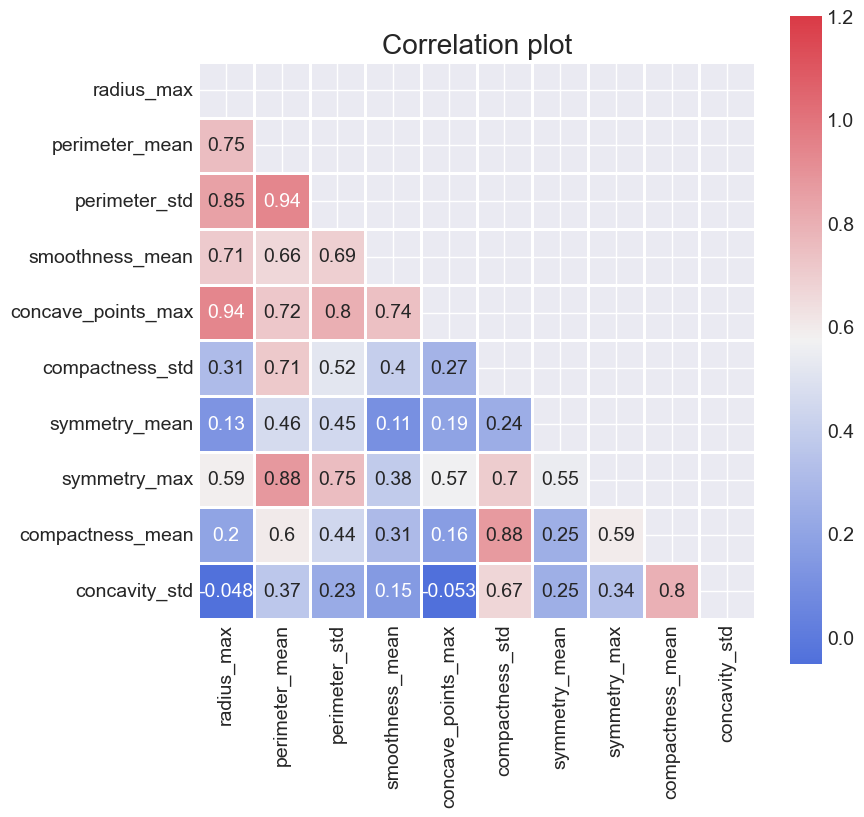

In [53]:
best_features_ever = ['radius_max', 'perimeter_mean', 'perimeter_std', 'smoothness_mean',
             'concave_points_max', 'compactness_std', 'symmetry_mean', 
             'symmetry_max', 'compactness_mean', 'concavity_std']
corr = train.loc[:, best_features_ever].corr()

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
data, ax = plt.subplots(figsize=(8, 8))
plt.title('Correlation plot')
cmap = sns.diverging_palette(260, 10, as_cmap=True)

sns.heatmap(corr, vmax=1.2, square='square', cmap=cmap, mask=mask, 
            ax=ax, annot=True, fmt='.2g',linewidths=2);

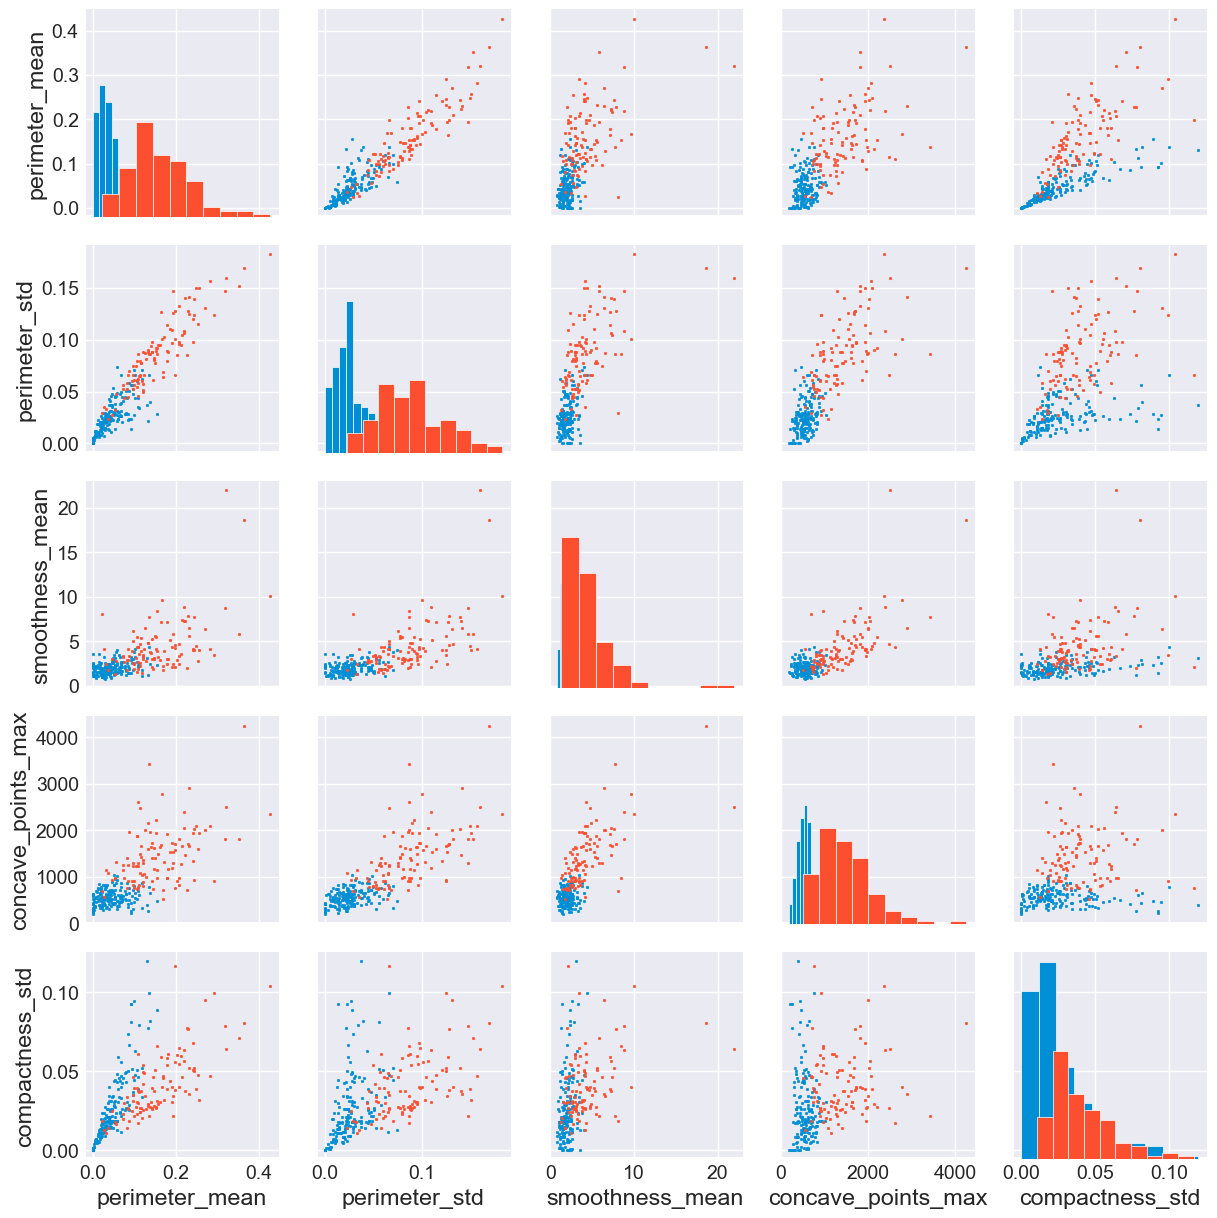

In [19]:
data = pd.concat([train.loc[:, best_features_ever], pd.Series(y, name='y')], axis=1)
g = sns.PairGrid(data[[data.columns[1],data.columns[2],data.columns[3],
                     data.columns[4], data.columns[5], 'y']], hue='y' )
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter, s = 3)

In [20]:
m = data[data["y"] == 1]
b = data[data["y"] == 0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_12176\4146052279.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(m[feature], label="1", ax=axes[i], color='r')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12176\4146052279.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(b[feature], label="0", a

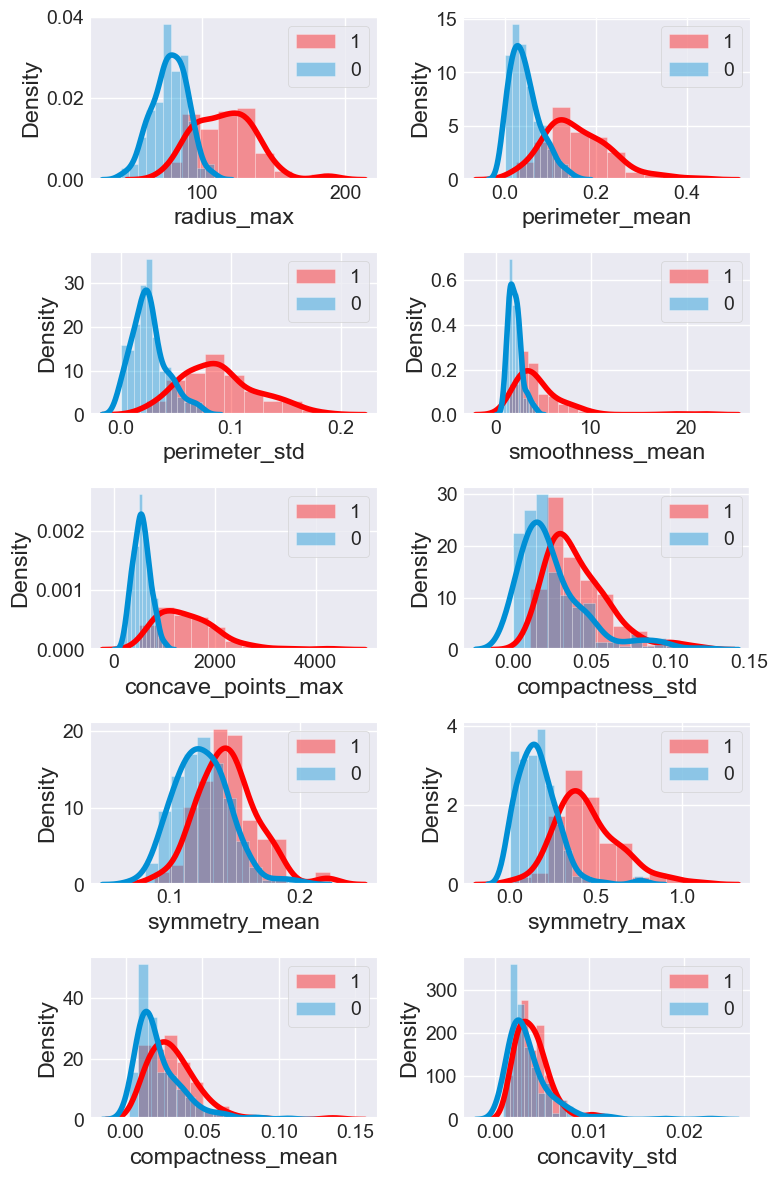

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(8,12))
axes = ax.ravel()
for i, feature in enumerate(best_features_ever):
    sns.distplot(m[feature], label="1", ax=axes[i], color='r')
    sns.distplot(b[feature], label="0", ax=axes[i])
    axes[i].legend()
plt.tight_layout();

## Baseline

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
f1_score(dt.predict(X_test), y_test)

0.8695652173913044

In [25]:
def optimize_model(model, param_grid):
    grid_search = GridSearchCV(model,
                              param_grid=param_grid,
                              cv=10)
    grid_search.fit(X_scaled, y)
    print("Best Score: {}".format(grid_search.best_score_))
    print("Best params: {}".format(grid_search.best_params_))
    return grid_search.best_estimator_

## Random Forest

In [27]:
parameter_grid = {'n_estimators': [20, 25, 30],
                  'max_depth': np.logspace(0,2,10),
                  'max_features': list(range(1,11))}
rf = optimize_model(RandomForestClassifier(), parameter_grid)

NameError: name 'X_scaled' is not defined

In [28]:
rf_test = RandomForestClassifier(**{'max_depth': 7.742636826811269, 
                                    'max_features': 10, 'n_estimators': 20, 'warm_start': True})
scaler = StandardScaler()
rf_test.fit(scaler.fit_transform(X_train), y_train)

RandomForestClassifier(max_depth=7.742636826811269, max_features=10,
                       n_estimators=20, warm_start=True)

In [29]:
y_pred = (rf_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

0.8333333333333333

In [30]:
confusion_matrix(y_pred, y_test)

array([[15,  3],
       [ 1, 10]], dtype=int64)

## Gradient Boosting

In [32]:
parameter_grid = {'n_estimators': [30, 50],
                  'max_depth': np.logspace(0,2,10),
                  'max_features': list(range(1,11)),
                  'learning_rate': np.logspace(0.001, 1, 10)}
gb = optimize_model(GradientBoostingClassifier(), parameter_grid)

NameError: name 'X_scaled' is not defined

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [34]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                                     'max_depth': 2.7825594022071245, 
                                                     'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

GradientBoostingClassifier(learning_rate=1.0023052380778996,
                           max_depth=2.7825594022071245, max_features=7,
                           n_estimators=30)

In [35]:
y_pred = (gb_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

0.88

In [36]:
confusion_matrix(y_pred, y_test)

array([[15,  3],
       [ 0, 11]], dtype=int64)

## Feature selection

Select K Best with chi2

In [37]:
from sklearn.feature_selection import SelectKBest, chi2

In [38]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
best_chi2_feature_names = list(featureScores.nlargest(10,'Score')['Specs'])

In [39]:
best_chi2_feature_names

['concave_points_max',
 'texture_mean',
 'smoothness_std',
 'concave_points_std',
 'radius_max',
 'concavity_max',
 'smoothness_mean',
 'radius_mean',
 'concave_points_mean',
 'radius_std']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, best_chi2_feature_names], y, test_size=0.1)

In [41]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                        'max_depth': 2.7825594022071245, 
                                        'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

GradientBoostingClassifier(learning_rate=1.0023052380778996,
                           max_depth=2.7825594022071245, max_features=7,
                           n_estimators=30)

In [42]:
y_pred = (gb_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

1.0

In [43]:
confusion_matrix(y_pred, y_test)

array([[19,  0],
       [ 0, 10]], dtype=int64)

Feature importances with trees

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                        'max_depth': 2.7825594022071245, 
                                        'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

получить наиболее важные признаки

In [ ]:
feat_importances = pd.Series(gb_test.feature_importances_, index=X.columns)
best_tree_feature_names = list(feat_importances.nlargest(10).index)

In [54]:
best_tree_feature_names

['concave_points_std',
 'concave_points_max',
 'perimeter_mean',
 'symmetry_mean',
 'area_std',
 'fractal_dimension_mean',
 'compactness_mean',
 'symmetry_max',
 'fractal_dimension_max',
 'concave_points_mean']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, best_tree_feature_names], y, test_size=0.5)

In [49]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                        'max_depth': 2.7825594022071245, 
                                        'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

GradientBoostingClassifier(learning_rate=1.0023052380778996,
                           max_depth=2.7825594022071245, max_features=7,
                           n_estimators=30)

In [50]:
y_pred = (gb_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

0.9523809523809524

In [51]:
confusion_matrix(y_pred, y_test)

array([[87,  3],
       [ 2, 50]], dtype=int64)